In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
import pandas.core.algorithms as algos
from pandas import Series
import scipy.stats.stats as stats
import re
import traceback
import string
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
import shap

In [2]:
#Load in data
dogData = pd.read_csv('cleanedDogData.csv', index_col = 'PetID')
catData = pd.read_csv('cleanedCatData.csv', index_col = 'PetID')

In [3]:
dogData.head(3)

,Age,Quantity,Fee,VideoAmt,Description,PhotoAmt,AdoptionSpeed,PureBreed_0,PureBreed_1,Breed_20,...,kind,little,lovely,playful,puppy,shelter,siblings,stray,sweet,trained
PetID,,,,,,,,,,,,,,,,,,,,,
3422e4906,1,1,0,0,Their pregnant mother was dumped by her irresp...,7,0,1,0,0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
5842f1ff5,4,1,150,0,"Good guard dog, very alert, active, obedience ...",8,0,1,0,0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
850a43f90,1,1,0,0,This handsome yet cute boy is up for adoption....,3,0,1,0,0,...,0.0,0.0,0.0,0.225212,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
catData.head(3)

,Age,Quantity,Fee,VideoAmt,Description,PhotoAmt,AdoptionSpeed,PureBreed_0,PureBreed_1,Breed_243,...,kittens,little,lovely,old,playful,rescued,siblings,stray,sweet,trained
PetID,,,,,,,,,,,,,,,,,,,,,
86e1089a3,3,1,100,0,Nibble is a 3+ month old ball of cuteness. He ...,1,0,0,1,0,...,0.0,0.240664,0.0,0.206106,0.182644,0.232571,0.0,0.000000,0.0,0.0
6296e909a,1,1,0,0,I just found it alone yesterday near my apartm...,2,0,0,1,0,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0
d24c30b4b,3,1,0,0,This is a stray kitten that came to my house. ...,2,0,0,1,0,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.675031,0.0,0.0


Split predictor and response variables into separate dataframes.

In [5]:
X_dog = dogData.drop(columns = 'AdoptionSpeed')
y_dog = dogData.AdoptionSpeed
X_cat = catData.drop(columns = 'AdoptionSpeed')
y_cat = catData.AdoptionSpeed

Split data into train & test.

In [6]:
X_train_dog, X_test_dog, y_train_dog, y_test_dog = train_test_split(X_dog, y_dog, test_size=0.3, random_state=42)
X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(X_cat, y_cat, test_size=0.3, random_state=42)

In [7]:
max_bin = 20
force_bin = 3

# define a binning function
def mono_bin(Y, X, n = max_bin):
    
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]
    r = 0
    while np.abs(r) < 1:
        try:
            d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.qcut(notmiss.X, n)})
            d2 = d1.groupby('Bucket', as_index=True)
            r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
            n = n - 1 
        except Exception as e:
            n = n - 1

    if len(d2) == 1:
        n = force_bin         
        bins = algos.quantile(notmiss.X, np.linspace(0, 1, n))
        if len(np.unique(bins)) == 2:
            bins = np.insert(bins, 0, 1)
            bins[1] = bins[1]-(bins[1]/2)
        d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.cut(notmiss.X, np.unique(bins),include_lowest=True)}) 
        d2 = d1.groupby('Bucket', as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["MIN_VALUE"] = d2.min().X
    d3["MAX_VALUE"] = d2.max().X
    d3["COUNT"] = d2.count().Y
    d3["EVENT"] = d2.sum().Y
    d3["NONEVENT"] = d2.count().Y - d2.sum().Y
    d3=d3.reset_index(drop=True)
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]       
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    
    return(d3)

def char_bin(Y, X):
        
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]    
    df2 = notmiss.groupby('X',as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["COUNT"] = df2.count().Y
    d3["MIN_VALUE"] = df2.sum().Y.index
    d3["MAX_VALUE"] = d3["MIN_VALUE"]
    d3["EVENT"] = df2.sum().Y
    d3["NONEVENT"] = df2.count().Y - df2.sum().Y
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]      
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    d3 = d3.reset_index(drop=True)
    
    return(d3)

def data_vars(df1, target):
    
    stack = traceback.extract_stack()
    filename, lineno, function_name, code = stack[-2]
    vars_name = re.compile(r'\((.*?)\).*$').search(code).groups()[0]
    final = (re.findall(r"[\w']+", vars_name))[-1]
    
    x = df1.dtypes.index
    count = -1
    
    for i in x:
        if i.upper() not in (final.upper()):
            if np.issubdtype(df1[i], np.number) and len(Series.unique(df1[i])) > 2:
                conv = mono_bin(target, df1[i])
                conv["VAR_NAME"] = i
                count = count + 1
            else:
                conv = char_bin(target, df1[i])
                conv["VAR_NAME"] = i            
                count = count + 1
                
            if count == 0:
                iv_df = conv
            else:
                iv_df = iv_df.append(conv,ignore_index=True)
    
    iv = pd.DataFrame({'IV':iv_df.groupby('VAR_NAME').IV.max()})
    iv = iv.reset_index()
    return(iv_df,iv)

In [8]:
final_iv_dog, IV_dog = data_vars(X_train_dog, y_train_dog)
final_iv_cat, IV_cat = data_vars(X_train_cat, y_train_cat)

divide by zero encountered in log
divide by zero encountered in log


In [9]:
# Check if any variables have an exceptionally high information value
print(list(IV_dog[(IV_dog['IV'] >= 0.8)]['VAR_NAME']))
print(list(IV_cat[(IV_cat['IV'] >= 0.8)]['VAR_NAME']))

[]
[]


Looking at the Variance Inflation Factor of the dependent variables.

In [10]:
def iterate_vif(df, vif_threshold=5, max_vif=6):
    count = 0
    while max_vif > vif_threshold:
        count += 1
        print("Iteration # "+str(count))
        vif = pd.DataFrame()
        vif["VIFactor"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
        vif["features"] = df.columns

        if vif['VIFactor'].max() > vif_threshold:
            print('Removing %s with VIF of %f' % (vif[vif['VIFactor'] == vif['VIFactor'].max()]['features'].values[0], vif['VIFactor'].max()))
            df = df.drop(vif[vif['VIFactor'] == vif['VIFactor'].max()]['features'].values[0], axis=1)
            max_vif = vif['VIFactor'].max()
        else:
            print('Complete')
            return df, vif.sort_values('VIFactor')

In [11]:
import warnings
warnings.filterwarnings("ignore")
final_df_dog, final_vif_dog = iterate_vif(X_train_dog._get_numeric_data())
final_df_cat, final_vif_cat = iterate_vif(X_train_cat._get_numeric_data())

Iteration # 1
Removing PureBreed_0 with VIF of inf
Iteration # 2
Removing Breed_20 with VIF of inf
Iteration # 3
Removing Gender_1 with VIF of inf
Iteration # 4
Removing NumColor1 with VIF of inf
Iteration # 5
Removing Color_1 with VIF of inf
Iteration # 6
Removing Size_1 with VIF of inf
Iteration # 7
Removing FurLength_1 with VIF of inf
Iteration # 8
Removing Vaccinated_0 with VIF of inf
Iteration # 9
Removing Dewormed_0 with VIF of inf
Iteration # 10
Removing Sterilized_0 with VIF of inf
Iteration # 11
Removing Health_0 with VIF of inf
Iteration # 12
Removing State_41326 with VIF of 102.582766
Iteration # 13
Removing Health_1 with VIF of 25.300665
Iteration # 14
Removing Breed_307 with VIF of 14.185171
Iteration # 15
Removing Size_2 with VIF of 5.320294
Iteration # 16
Complete
Iteration # 1
Removing PureBreed_0 with VIF of inf
Iteration # 2
Removing Breed_243 with VIF of inf
Iteration # 3
Removing Gender_1 with VIF of inf
Iteration # 4
Removing NumColor_1 with VIF of inf
Iteration # 

In [12]:
X_train_dog = final_df_dog
X_train_cat = final_df_cat

In [13]:
X_test_dog=X_test_dog[X_train_dog.columns]
X_test_cat=X_test_cat[X_train_cat.columns]

### Logistic Regression 

In [16]:
def run_regression_accuracy(X_train, y_train, X_test, y_test):
    logreg = LogisticRegression()
    logreg.fit(X_train, y_train)
    y_pred = logreg.predict(X_test)
    y_pred_proba = logreg.predict_proba(X_test)[:,1]
    print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))
    cm = confusion_matrix(y_test, y_pred)
    print('\nConfusion matrix: \n',cm)

    print('\nClassification report: \n',classification_report(y_test, y_pred))
    logit_roc_auc = roc_auc_score(y_test, y_pred_proba)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

    plt.figure()
    plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    
    print('\nROC on training data: ', roc_auc_score(y_train, logreg.predict_proba(X_train)[:,1]))

    return logreg

#### Logistic regression for dog adoption

Accuracy of logistic regression classifier on test set: 0.73

Confusion matrix: 
 [[1520   95]
 [ 537  155]]

Classification report: 
               precision    recall  f1-score   support

           0       0.74      0.94      0.83      1615
           1       0.62      0.22      0.33       692

    accuracy                           0.73      2307
   macro avg       0.68      0.58      0.58      2307
weighted avg       0.70      0.73      0.68      2307



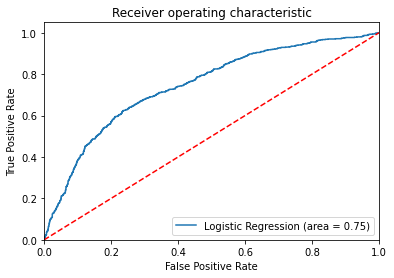


ROC on training data:  0.7254601659400088


In [17]:
logreg_dog = run_regression_accuracy(X_train_dog, y_train_dog, X_test_dog, y_test_dog)

#### Logistic regression for cat adoption

Accuracy of logistic regression classifier on test set: 0.76

Confusion matrix: 
 [[1413   57]
 [ 420   86]]

Classification report: 
               precision    recall  f1-score   support

           0       0.77      0.96      0.86      1470
           1       0.60      0.17      0.27       506

    accuracy                           0.76      1976
   macro avg       0.69      0.57      0.56      1976
weighted avg       0.73      0.76      0.70      1976



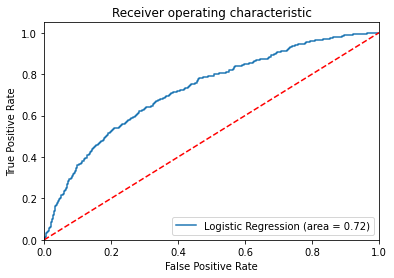


ROC on training data:  0.721388941277114


In [18]:
logreg_cat = run_regression_accuracy(X_train_cat, y_train_cat, X_test_cat, y_test_cat)

### Random Forest

In [19]:
def run_random_forest(X_train, X_test, y_train, y_test):
    # Instantiate model with 1000 decision trees
    rf = RandomForestClassifier(n_estimators = 10, random_state = 42)
    # Train the model on training data
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    y_pred_proba = rf.predict_proba(X_test)[:,1]
    
    print('Accuracy of random forest classifier on test set: {:.2f}'.format(rf.score(X_test, y_test)))
    cm = confusion_matrix(y_test, y_pred)
    print('\nConfusion matrix: \n',cm)

    print('\nClassification report: \n',classification_report(y_test, y_pred))

    rf_roc_auc = roc_auc_score(y_test, y_pred_proba)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

    plt.figure()
    plt.plot(fpr, tpr, label='Random Forest Classifier (area = %0.2f)' % rf_roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    
    print('\nROC on training data: ', roc_auc_score(y_train, rf.predict_proba(X_train)[:,1]))
    
    return rf

#### Random forest classifier for dog adoption

Accuracy of random forest classifier on test set: 0.74

Confusion matrix: 
 [[1458  157]
 [ 447  245]]

Classification report: 
               precision    recall  f1-score   support

           0       0.77      0.90      0.83      1615
           1       0.61      0.35      0.45       692

    accuracy                           0.74      2307
   macro avg       0.69      0.63      0.64      2307
weighted avg       0.72      0.74      0.71      2307



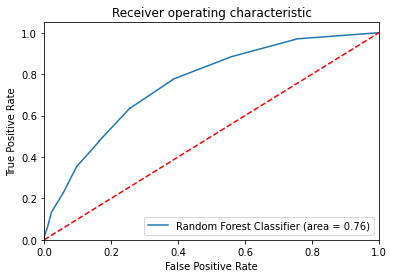


ROC on training data:  0.9990629182290224


RandomForestClassifier(n_estimators=10, random_state=42)

In [20]:
run_random_forest(X_train_dog, X_test_dog, y_train_dog, y_test_dog)

#### Random forest classifier for cat adoption

Accuracy of random forest classifier on test set: 0.77

Confusion matrix: 
 [[1383   87]
 [ 372  134]]

Classification report: 
               precision    recall  f1-score   support

           0       0.79      0.94      0.86      1470
           1       0.61      0.26      0.37       506

    accuracy                           0.77      1976
   macro avg       0.70      0.60      0.61      1976
weighted avg       0.74      0.77      0.73      1976



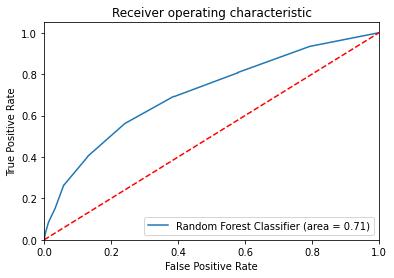


ROC on training data:  0.9991286297335843


RandomForestClassifier(n_estimators=10, random_state=42)

In [21]:
run_random_forest(X_train_cat, X_test_cat, y_train_cat, y_test_cat)

### XGBoost

In [22]:
def run_XGB_classifier(X_train, X_test, y_train, y_test):
    data_dmatrix = xgb.DMatrix(data=X_train,label=y_train)
    xgb_cla = xgb.XGBClassifier(use_label_encoder=False, colsample_bytree = 0.3, learning_rate = 0.1,
                    max_depth = 5, alpha = 10, n_estimators = 10)
    xgb_cla.fit(X_train, y_train)
    y_pred = xgb_cla.predict(X_test)
    y_pred_proba = xgb_cla.predict_proba(X_test)[:, 1]
    
    print('Accuracy of XGB classifier on test set: {:.2f}'.format(xgb_cla.score(X_test, y_test)))
    cm = confusion_matrix(y_test, y_pred)
    print('\nConfusion matrix: \n',cm)

    print('\nClassification report: \n',classification_report(y_test, y_pred))

    xgb_roc_auc = roc_auc_score(y_test, y_pred_proba)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

    plt.figure()
    plt.plot(fpr, tpr, label='XGB Classifier (area = %0.2f)' % xgb_roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

    print('\nROC on training data: ', roc_auc_score(y_train, xgb_cla.predict_proba(X_train)[:, 1]))
    
    return xgb_cla


#### XGBoost classifier for dog adoption

[11:05:19] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy of XGB classifier on test set: 0.70

Confusion matrix: 
 [[1615    0]
 [ 691    1]]

Classification report: 
               precision    recall  f1-score   support

           0       0.70      1.00      0.82      1615
           1       1.00      0.00      0.00       692

    accuracy                           0.70      2307
   macro avg       0.85      0.50      0.41      2307
weighted avg       0.79      0.70      0.58      2307



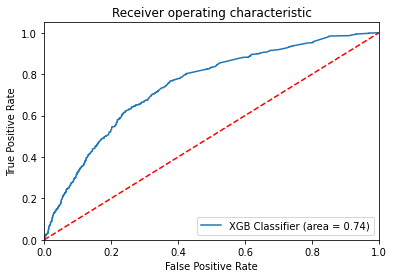


ROC on training data:  0.7539354780932985


XGBClassifier(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=10, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=10, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [23]:
run_XGB_classifier(X_train_dog, X_test_dog, y_train_dog, y_test_dog)

#### XGBoost classifier for cat adoption

[11:05:25] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy of XGB classifier on test set: 0.74

Confusion matrix: 
 [[1470    0]
 [ 506    0]]

Classification report: 
               precision    recall  f1-score   support

           0       0.74      1.00      0.85      1470
           1       0.00      0.00      0.00       506

    accuracy                           0.74      1976
   macro avg       0.37      0.50      0.43      1976
weighted avg       0.55      0.74      0.63      1976



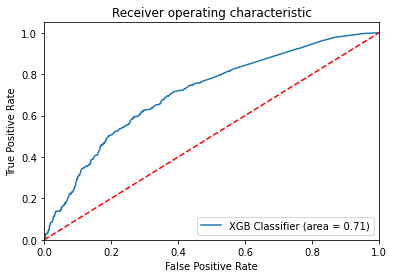


ROC on training data:  0.7335904670687617


XGBClassifier(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=10, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=10, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [24]:
run_XGB_classifier(X_train_cat, X_test_cat, y_train_cat, y_test_cat)

The best model is Random Forest with an AUC score of 0.65 for dogs and 0.61 for cats.  Now let's perform grid search CV to determine the best parameters for this model.

## Grid Search on Random Forest Classifier

In [21]:
def gridSearch(X_train, y_train):
    param_grid = { 
        'n_estimators': [400, 450, 500, 550],
        'max_features': ['auto', 'sqrt', 'log2'],
        'max_depth' : [15, 20, 25, 30, 35, 40],
        'criterion' :['gini', 'entropy']
    }
    rfc = RandomForestClassifier(random_state = 42)
    rfc_cv = GridSearchCV(estimator=rfc, param_grid=param_grid, scoring='roc_auc', cv= 5)
    rfc_cv.fit(X_train, y_train)
    return rfc_cv

In [22]:
dog_rfc_cv = gridSearch(X_train_dog, y_train_dog)
cat_rfc_cv = gridSearch(X_train_cat, y_train_cat)

In [23]:
print("Best Score:" + str(dog_rfc_cv.best_score_))
print("Best Parameters: " + str(dog_rfc_cv.best_params_))

Best Score:0.7849566025719156
Best Parameters: {'criterion': 'entropy', 'max_depth': 35, 'max_features': 'log2', 'n_estimators': 450}


In [24]:
print("Best Score:" + str(cat_rfc_cv.best_score_))
print("Best Parameters: " + str(cat_rfc_cv.best_params_))

Best Score:0.7547047160953705
Best Parameters: {'criterion': 'entropy', 'max_depth': 20, 'max_features': 'log2', 'n_estimators': 500}


### Fit best model to dog adoption data

In [38]:
rfc_dog = RandomForestClassifier(random_state = 42, max_features='log2', n_estimators= 450, max_depth=35, criterion='entropy')
rfc_dog.fit(X_train_dog, y_train_dog)

RandomForestClassifier(criterion='entropy', max_depth=35, max_features='log2',
                       n_estimators=450, random_state=42)

In [39]:
y_pred_dog=rfc_dog.predict(X_test_dog)

In [40]:
print("Accuracy for Random Forest on dog adoption data: ",accuracy_score(y_test_dog,y_pred_dog))

Accuracy for Random Forest on dog adoption data:  0.7598612917208496


In [41]:
print(roc_auc_score(y_test_dog, y_pred_dog))

0.6496774280141019


### Fit best model to cat adoption data

In [42]:
rfc_cat = RandomForestClassifier(random_state = 42, max_features='log2', n_estimators= 500, max_depth=20, criterion='entropy')
rfc_cat.fit(X_train_cat, y_train_cat)

RandomForestClassifier(criterion='entropy', max_depth=20, max_features='log2',
                       n_estimators=500, random_state=42)

In [43]:
y_pred_cat=rfc_cat.predict(X_test_cat)

In [44]:
print("Accuracy for Random Forest on cat adoption data: ",accuracy_score(y_test_cat,y_pred_cat))

Accuracy for Random Forest on cat adoption data:  0.7606275303643725


In [45]:
print(roc_auc_score(y_test_cat, y_pred_cat))

0.5488088516038826


## SHAP analysis

### SHAP analysis for dog adoption

In [46]:
shap_values_dog = shap.TreeExplainer(rfc_dog).shap_values(X_train_dog)

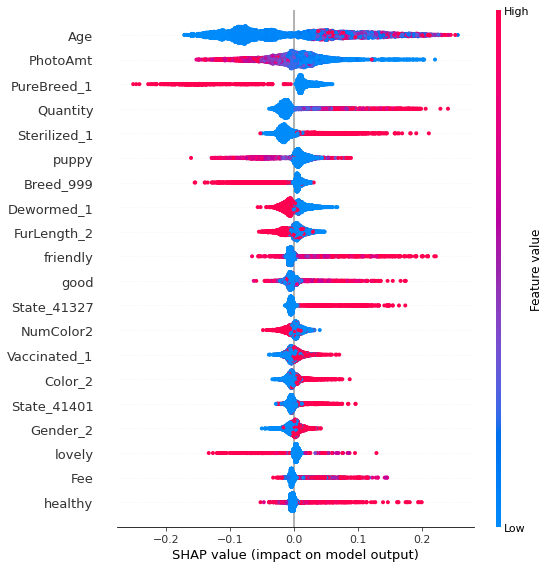

In [47]:
shap.summary_plot(shap_values_dog[1], X_train_dog)

We can describe the model. A adoption made within 100 days is associated with the following characteristics:

<br>
<ul>
<li> Young age </li>
<li> High photo amount </li>
<li> Pure breed </li>
<li> Smaller quanity of dogs in each listing </li>
<li> Is not sterilized </li>
<li> Has the keyword 'puppy' in it's profile description </li>
<li> Is of breed_999 </li>
<li> Is dewormed </li>
<li> Has the keyword 'friendly' (not very interpretable) </li>
<li> Is of 'FurLength_2' (medium/long) </li>
<li> Has the keyword 'good' in it's profile description </li>
<li> Is not in State_413727 </li>
<li> Has 2 colors </li>
<li> Doesn't have Color_2 (Brown) as their dominant color </li>
<li> Is not of Gender_2 (Female) </li>
<li> Has a high Fee (inconclusive) </li>
<li> State_41401 - inconclusive </li>
<li> 'healthy' - inconclusive </li>
<li> Has the keyword 'lovely' in it's profile description - inconclusive </li>
<li> Is not vaccinated (reflects age) </li>
</ul>

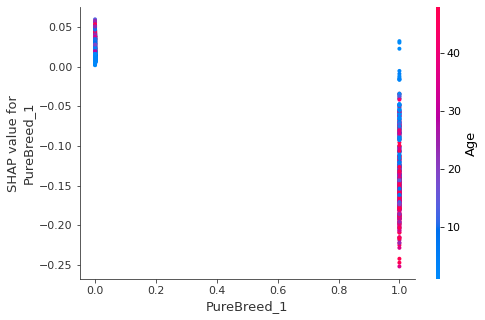

In [48]:
shap.dependence_plot("PureBreed_1", shap_values_dog[1], X_train_dog)

### SHAP analysis for cat adoption

In [49]:
shap_values_cat = shap.TreeExplainer(rfc_cat).shap_values(X_train_cat)

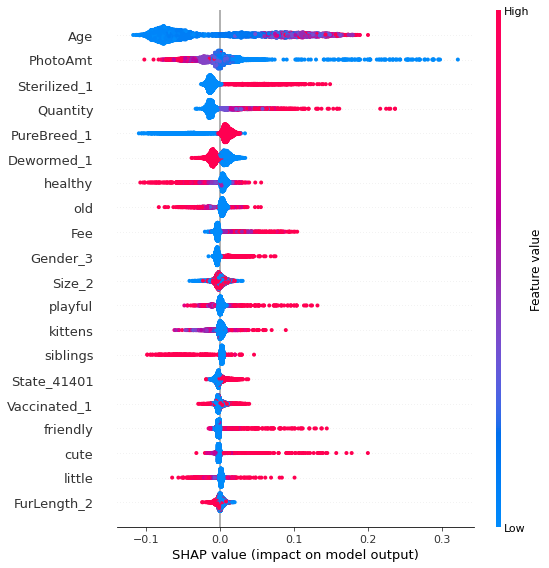

In [50]:
shap.summary_plot(shap_values_cat[1], X_train_cat)

We can describe the model. A adoption made within 100 days is associated with the following characteristics:

<br>
<ul>
    <li> Young age </li>
    <li> High photo amount </li>
    <li> Is not sterilized </li>
    <li> Smaller quanity of cats in each listing </li>
    <li> Is of mixed breed </li>
    <li> Is dewormed </li>
    <li> Has the keyword 'healthy' in it's profile description </li>
    <li> Has the keyword 'old' (not very interpretable) </li>
    <li> Has low adoption fees </li>
    <li> Is not of Gender_3 (Mixed gender) </li>
    <li> Is of 'Size_2' (medium) </li>
    <li> Has the keyword 'playful' in it's profile description (not very interpretable) </li>
    <li> Has the keyword 'kittens' in it's profile description (not very interpretable) </li>
    <li> Has the keyword 'siblings' in it's profile description (not very interpretable) </li>


    <li> Is not in State_413727 </li>
    <li> Has 2 colors </li>
    <li> Doesn't have Color_2 (Brown) as their dominant color </li>
    <li> Has a high Fee (inconclusive) </li>
    <li> State_41401 - inconclusive </li>
    <li> 'healthy' - inconclusive </li>
    <li> Has the keyword 'lovely' in it's profile description - inconclusive </li>
    <li> Is not vaccinated (reflects age) </li>
</ul>